#### Data Preparation & Cleaning

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

from sklearn.metrics import precision_recall_curve, classification_report, f1_score
import numpy as np


from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, f1_score, roc_curve, auc
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression
from sklearn.inspection import permutation_importance
from sklearn.decomposition import PCA
import lightgbm as lgb
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from pymongo import MongoClient 
import pandas as pd
import numpy as np
from datetime import datetime
import warnings

def flatten_nested_docs(df: pd.DataFrame) -> pd.DataFrame:
    """Flattens any dict‐typed columns in the DataFrame."""
    flat = df.copy()
    # Identify columns whose first value is a dict
    doc_cols = [c for c in flat.columns
                if len(flat) > 0 and isinstance(flat[c].iloc[0], dict)]
    
    for col in doc_cols:
        # Normalize the list of dicts into a DataFrame
        nested = pd.json_normalize(flat[col])
        nested.columns = [f"{col}_{sub}" for sub in nested.columns]
        flat = flat.drop(columns=[col]).reset_index(drop=True)
        flat = pd.concat([flat, nested.reset_index(drop=True)], axis=1)
    return flat

def rename_and_clean(df: pd.DataFrame) -> pd.DataFrame:
    """Adds a time column, reorders, drops and renames columns per spec."""
    # 1) Add current timestamp and move to front
    df['time'] = pd.Timestamp.now()
    cols = ['time'] + [c for c in df.columns if c != 'time']
    df = df[cols]

    df = df.drop(['pair_createdAt', 'pair_updatedAt'], axis=1)
    
    # Create a boolean mask where token0 is Solana
    mask_solana = df['pair_token0.name'] == 'Solana'

    # np.where to pick values from token1 when token0 is Solana, else from token0
    df['price1'] = np.where(
        mask_solana,
        df['pair_token1.price'],
        df['pair_token0.price']
    )

    df['fullyDilutedValuation'] = np.where(
        mask_solana,
        df['pair_token1.fdv'],
        df['pair_token0.fdv']
    )

    df['marketCap'] = np.where(
        mask_solana,
        df['pair_token1.marketCap'],
        df['pair_token0.marketCap']
    )

    df['totalSupply'] = np.where(
        mask_solana,
        df['pair_token1.totalSupply'],
        df['pair_token0.totalSupply']
    )

    df['circulatingSupply'] = np.where(
        mask_solana,
        df['pair_token1.circulatingSupply'],
        df['pair_token0.circulatingSupply']
    )

    df['name'] = np.where(
        mask_solana,
        df['pair_token1.name'],
        df['pair_token0.name']
    )
    
    
    # 2) Apply your custom renames
    df = df.rename(columns={
        'tweetscoutScore': 'tweetscout_score',
        'tokenName': 'name',
        'fullyDilutedValuation': 'fdv',
        'ticker': 'symbol',
        'totalSupply': 'total_supply',
        'marketCap': 'market_cap',
        'circulatingSupply': 'circulating_supply',
        'pair_priceChange.m1': 'variation_1m',
        'pair_priceChange.m5': 'variation_5m',
        'pair_priceChange.m15': 'variation_15m',
        'pair_priceChange.h1': 'variation_1h',
        'pair_priceChange.h4': 'variation_4h',
        'pair_priceChange.h12': 'variation_12h',
        'pair_priceChange.h24': 'variation_24h',
    })

    # 3) Strip common prefixes
    df.columns = df.columns.str.replace(r'^score_', '', regex=True)
    df.columns = df.columns.str.replace(r'^pair_', '', regex=True)
    df = df.drop(['price'], axis=1)
    df = df.rename(columns={'price1': 'price'})
    
    return df


def main():
    # --- 1) Connect & Load ---
    uri = (
        "mongodb+srv://xfractalUserDev:mUKw4PJNfELe5Huv"
        "@cluster0.phu2c.mongodb.net/xfractal-develop"
        "?retryWrites=true&w=majority"
    )
    client = MongoClient(uri, serverSelectionTimeoutMS=60000)
    db = client["xfractal-develop"]
    
    try:
        print("Collections:", db.list_collection_names())
        raw = list(db["Tokens"].find())
    except Exception as e:
        print("Connection or fetch failed:", e)
        return
    
    df = pd.DataFrame(raw).drop(columns=['_id'], errors='ignore')
    
    # --- 2) Flatten any nested dict columns ---
    df = flatten_nested_docs(df)
    
    # --- 3) Clean up & rename columns ---
    df = rename_and_clean(df)
    
    # --- 4) Preview & return ---
    print("\nFinal schema:", df.columns.tolist())
    print(df.head())
    return df

if __name__ == '__main__':
    final_df = main()

Collections: ['WalletsConnected', 'Blockchains', 'Feed', 'Telegram', 'ChatHistory', 'Users', 'Sessions', 'Checkpoints', 'Orders', 'CheckpointWrites', 'Watchlists', 'Order', 'Security', 'Wallets', 'Allora', 'Tokens', 'Positions', 'XccConversions']

Final schema: ['time', 'score', 'tweetscout_score', 'followers', 'createdAt', 'updatedAt', 'mcAtPrediction', 'prediction', 'priceAtPrediction', 'lastUpdated', 'confidence', 'threshold', 'volume24h', 'liquidity', 'blockchain', 'baseToken', 'exchangeLogo', 'address', 'type', 'exchangeName', 'solanaPrice', 'token0.address', 'token0.price', 'token0.symbol', 'token0.name', 'token0.totalSupply', 'token0.circulatingSupply', 'token0.logo', 'token0.marketCap', 'token0.fdv', 'token1.address', 'token1.price', 'token1.symbol', 'token1.name', 'token1.totalSupply', 'token1.circulatingSupply', 'token1.logo', 'token1.marketCap', 'token1.fdv', 'variation_1m', 'variation_5m', 'variation_1h', 'variation_4h', 'variation_12h', 'variation_24h', 'trades.m1', 'trade

In [2]:
final_df.shape

(36199, 114)

In [3]:
final_df.head()

,time,score,tweetscout_score,followers,createdAt,updatedAt,mcAtPrediction,prediction,priceAtPrediction,lastUpdated,...,traders.h1,traders.h4,traders.h12,traders.h24,price,fdv,market_cap,total_supply,circulating_supply,name
0,2025-05-15 12:18:47.361014,None,NaN,None,2025-04-25 16:45:05.440,2025-04-25 16:45:05.440,NaN,NaN,NaN,NaT,...,NaN,NaN,NaN,NaN,0.002863,2.833547e+06,2.832265e+06,9.896064e+08,9.891588e+08,MEMDEX100
1,2025-05-15 12:18:47.361014,None,NaN,None,2025-04-25 16:45:07.319,2025-04-25 16:45:07.319,NaN,NaN,NaN,NaT,...,NaN,NaN,NaN,NaN,0.007155,7.154564e+12,7.224788e+06,1.000000e+15,1.009815e+09,PVS
2,2025-05-15 12:18:47.361014,None,NaN,None,2025-04-25 16:45:17.917,2025-04-25 16:45:17.917,NaN,NaN,NaN,NaT,...,NaN,NaN,NaN,NaN,0.002836,2.836384e+12,2.836876e+06,1.000000e+15,1.000173e+09,Swasticoin
3,2025-05-15 12:18:47.361014,None,NaN,None,2025-04-25 16:45:41.474,2025-04-25 16:45:41.474,NaN,NaN,NaN,NaT,...,NaN,NaN,NaN,NaN,0.031647,3.164709e+13,3.195613e+07,1.000000e+15,1.009765e+09,Dark Eclipse
4,2025-05-15 12:18:47.361014,None,NaN,None,2025-04-25 16:46:21.294,2025-04-25 16:46:21.294,NaN,NaN,NaN,NaT,...,NaN,NaN,NaN,NaN,0.000027,2.703754e+04,2.703754e+04,1.000000e+09,1.000000e+09,Slinky Dog


In [5]:
df = final_df.copy()

df['target'] = (df['variation_24h'] > 0).astype(int)

df['time'] = pd.to_datetime(df['time'])
df['hour'] = df['time'].dt.hour
df['day_of_week'] = df['time'].dt.dayofweek
df = df.sort_values(["name", "time"])

# Moving Averages (MAs)
df['price_ma_3']   = df.groupby("name")["price"].transform(lambda x: x.rolling(window=3, min_periods=1).mean())
df['price_ma_5']   = df.groupby("name")["price"].transform(lambda x: x.rolling(window=5, min_periods=1).mean())
df['price_ma_7']   = df.groupby("name")["price"].transform(lambda x: x.rolling(window=7, min_periods=1).mean())
df['price_ma_14']  = df.groupby("name")["price"].transform(lambda x: x.rolling(window=14, min_periods=1).mean())
df['price_ma_30']  = df.groupby("name")["price"].transform(lambda x: x.rolling(window=30, min_periods=1).mean())

# Price difference and volatility
df['price_diff'] = df.groupby("name")["price"].diff().fillna(0)
df['price_std_3'] = df.groupby("name")["price"].transform(lambda x: x.rolling(window=3, min_periods=1).std())
df['price_std_5'] = df.groupby("name")["price"].transform(lambda x: x.rolling(window=5, min_periods=1).std())

# Social metrics
#df['net_votes'] = df['upvotes'] - df['downvotes']
#df['tweescout_score_filled'] = df['tweescout_score'].fillna(df['tweescout_score'].median())
#df['composite_social'] = df['tweescout_score_filled'] + df['net_votes'].fillna(0)

# Lagged features (previous period price)
df['price_lag_1'] = df.groupby("name")["price"].shift(1).fillna(method='bfill')
df['price_return_1'] = (df['price'] - df['price_lag_1']) / df['price_lag_1']



# ----- RSI Calculation -----
def compute_rsi(series, period=14):
    delta = series.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    # Calculate the exponential moving average (EMA) for gains and losses
    avg_gain = gain.rolling(window=period, min_periods=period).mean()
    avg_loss = loss.rolling(window=period, min_periods=period).mean()
    # Prevent division by zero
    rs = avg_gain / (avg_loss.replace(0, 1e-6))
    rsi = 100 - (100 / (1 + rs))
    return rsi

df['RSI'] = df.groupby("name")["price"].transform(lambda x: compute_rsi(x, period=14))

# ----- MACD Calculation -----
def compute_macd(series, short_period=12, long_period=26, signal_period=9):
    ema_short = series.ewm(span=short_period, adjust=False).mean()
    ema_long = series.ewm(span=long_period, adjust=False).mean()
    macd_line = ema_short - ema_long
    signal_line = macd_line.ewm(span=signal_period, adjust=False).mean()
    macd_hist = macd_line - signal_line
    return macd_line, signal_line, macd_hist

# Compute MACD for each token
macd_results = df.groupby("name")["price"].transform(lambda x: compute_macd(x)[0])
signal_results = df.groupby("name")["price"].transform(lambda x: compute_macd(x)[1])
df['MACD'] = macd_results
df['MACD_Signal'] = signal_results

# ----- Bollinger Bands Calculation -----
def compute_bollinger_bands(series, window=20, num_std=2):
    ma = series.rolling(window=window, min_periods=1).mean()
    std = series.rolling(window=window, min_periods=1).std()
    upper_band = ma + num_std * std
    lower_band = ma - num_std * std
    return ma, upper_band, lower_band

bollinger_ma, bollinger_upper, bollinger_lower = zip(*df.groupby("name")["price"].apply(lambda x: compute_bollinger_bands(x)))
# Because of groupby, we can merge the results back. One way is to compute per row:
df['Bollinger_MA'] = df.groupby("name")["price"].transform(lambda x: x.rolling(window=20, min_periods=1).mean())
df['Bollinger_Upper'] = df.groupby("name")["price"].transform(lambda x: x.rolling(window=20, min_periods=1).mean() + 2 * x.rolling(window=20, min_periods=1).std())
df['Bollinger_Lower'] = df.groupby("name")["price"].transform(lambda x: x.rolling(window=20, min_periods=1).mean() - 2 * x.rolling(window=20, min_periods=1).std())


# Updating feature list to include these new features:
new_features = [
    "RSI", "MACD", "MACD_Signal"
]

existing_features = [
    "price", "variation_1m", "variation_5m", "variation_1h", "variation_4h", "variation_12h",
    "circulating_supply", "market_cap", "volume24h",
    "hour", "day_of_week", "volume.m1", "volume.m5", "volume.m15", "volume.h1", "volume.h4", "volume.h12", "volume.h24",
    "price_ma_3", "price_ma_5", "price_ma_7", "price_ma_14", "price_ma_30",
    "price_diff", "price_std_3", "price_std_5"
]

all_features = existing_features + new_features

# Fill missing values (if any) in new features
df[new_features] = df[new_features].fillna(method='bfill').fillna(method='ffill')

# Updating the feature set for model training:
df_features = df[all_features].copy()
df_features = df_features.fillna(df_features.median())



X = df_features
y = df['target'] 

C:\Users\DC MEDIA AGO\AppData\Local\Temp\ipykernel_9168\1864673977.py:28: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['price_lag_1'] = df.groupby("name")["price"].shift(1).fillna(method='bfill')
C:\Users\DC MEDIA AGO\AppData\Local\Temp\ipykernel_9168\1864673977.py:94: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[new_features] = df[new_features].fillna(method='bfill').fillna(method='ffill')


In [6]:
# -----------------------------------------
# 1) Compute the absolute correlation matrix
# -----------------------------------------
corr = df_features.corr().abs()

# -----------------------------------------
# 2) Select the upper triangle of the matrix
# -----------------------------------------
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))

# -----------------------------------------
# 3) Compute each feature’s correlation with the target
# -----------------------------------------
feat_target_corr = df_features.apply(lambda col: abs(col.corr(df['target'])))

# -----------------------------------------
# 4) For each high-corr pair, drop the weaker
# -----------------------------------------
threshold = 0.8
to_drop = set()

for col in upper.columns:
    for row in upper.index:
        if upper.at[row, col] > threshold:
            # only consider pairs not already slated for drop
            if row not in to_drop and col not in to_drop:
                # compare their correlation with target
                if feat_target_corr[row] >= feat_target_corr[col]:
                    to_drop.add(col)
                else:
                    to_drop.add(row)

print(f"Dropping {len(to_drop)} features (corr > {threshold}, weaker vs. target):")
print(sorted(to_drop))

# -----------------------------------------
# 5) Create a reduced DataFrame
# -----------------------------------------
df_reduced = df_features.drop(columns=list(to_drop))
print(f"Reduced from {df_features.shape[1]} to {df_reduced.shape[1]} features.")

# Use df_reduced downstream
X = df_reduced


# ------------------------------
# 3. Train/Test Split
# ------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ------------------------------
# 4. Scale & SMOTE
# ------------------------------
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s  = scaler.transform(X_test)

sm = SMOTE(random_state=42)
X_tr, y_tr = sm.fit_resample(X_train_s, y_train)



c:\Users\DC MEDIA AGO\Anaconda3\envs\hypescore\lib\site-packages\numpy\lib\_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\DC MEDIA AGO\Anaconda3\envs\hypescore\lib\site-packages\numpy\lib\_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Dropping 12 features (corr > 0.8, weaker vs. target):
['MACD_Signal', 'price', 'price_ma_14', 'price_ma_3', 'price_ma_30', 'price_ma_5', 'price_ma_7', 'price_std_3', 'variation_5m', 'volume.h1', 'volume.h24', 'volume.h4']
Reduced from 29 to 17 features.


In [7]:
# ------------------------------
# 5. Tune Base Models
# ------------------------------
class_weights = {0: 1, 1: sum(y_train==0)/sum(y_train==1)}
print("Class weights:", class_weights)
low_var = np.where(X_tr.var(axis=0) < 1e-4)[0]
if len(low_var):
    print("Low‐variance feature indices:", low_var)

cv = KFold(5, shuffle=True, random_state=42)

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", message="No further splits with positive gain")
    lgb_model = lgb.LGBMClassifier(
        class_weight=class_weights,
        bagging_fraction=0.8, bagging_freq=1,
        feature_fraction=0.8,
        learning_rate=0.05,
        max_depth=4, num_leaves=16,
        min_child_samples=20, lambda_l1=0.1, lambda_l2=0.1,
        n_estimators=200, verbosity=-1,
        random_state=42
    )
    lgb_model.fit(X_tr, y_tr)


xgb_model = xgb.XGBClassifier(
        scale_pos_weight=class_weights[1],
        learning_rate=0.05, max_depth=4, min_child_weight=1,
        subsample=0.8, colsample_bytree=0.8,
        n_estimators=200,
        objective='binary:logistic', eval_metric='logloss',
        random_state=42
    )
xgb_model.fit(X_tr, y_tr)


# ------------------------------
# 6. Stacking Ensemble
# ------------------------------
# --- 8) Build stacking meta‐learner and fit ---
meta = lgb.LGBMClassifier(
    learning_rate=0.05, n_estimators=100,
    num_leaves=16, verbosity=-1, random_state=42
    )
stack = StackingClassifier(
    estimators=[('lgb',lgb_model),('xgb',xgb_model)],
    final_estimator=meta,
    cv=cv, n_jobs=-1, passthrough=True
    )
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", message="No further splits with positive gain")
    stack = CalibratedClassifierCV(stack, cv=3)
    stack.fit(X_tr, y_tr)


# ------------------------------
# 7. Predict & Probabilities
# ------------------------------

# --- 9) Score and find F1‐optimal thresholds on the truly‐held‐out set ---
lgb_p  = lgb_model.predict(X_test_s)
lgb_pr = lgb_model.predict_proba(X_test_s)[:,1]
xgb_p  = xgb_model.predict(X_test_s)
xgb_pr = xgb_model.predict_proba(X_test_s)[:,1]
st_p   = stack.predict(X_test_s)
st_pr  = stack.predict_proba(X_test_s)[:,1]


Class weights: {0: 1, 1: 1.415464175494203}
Low‐variance feature indices: [7 8]


c:\Users\DC MEDIA AGO\Anaconda3\envs\hypescore\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\DC MEDIA AGO\Anaconda3\envs\hypescore\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\DC MEDIA AGO\Anaconda3\envs\hypescore\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\DC MEDIA AGO\Anaconda3\envs\hypescore\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\DC MEDIA AGO\Anaconda3\envs\hypescore\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid featur

In [18]:
print("LightGBM:\n",classification_report(y_test,lgb_p))
print("XGBoost:\n",classification_report(y_test,xgb_p))

LightGBM:
               precision    recall  f1-score   support

           0       0.91      0.83      0.87      4243
           1       0.79      0.88      0.83      2997

    accuracy                           0.85      7240
   macro avg       0.85      0.86      0.85      7240
weighted avg       0.86      0.85      0.85      7240

XGBoost:
               precision    recall  f1-score   support

           0       0.91      0.83      0.87      4243
           1       0.79      0.88      0.83      2997

    accuracy                           0.85      7240
   macro avg       0.85      0.86      0.85      7240
weighted avg       0.86      0.85      0.85      7240



In [19]:
print("Stack:\n",classification_report(y_test,st_p))
print("Stack AUC:",auc(*roc_curve(y_test,st_pr)[:2]))

Stack:
               precision    recall  f1-score   support

           0       0.90      0.86      0.88      4243
           1       0.82      0.87      0.84      2997

    accuracy                           0.87      7240
   macro avg       0.86      0.87      0.86      7240
weighted avg       0.87      0.87      0.87      7240

Stack AUC: 0.9442775716245746


In [20]:
from sklearn.metrics import precision_recall_curve, classification_report, f1_score
import numpy as np

# ------------------------------
# 8. Threshold Tuning (maximize F1)
# ------------------------------
def find_best_threshold(y_true, y_probs):
    """
    Find the threshold that maximizes the F1 score.
    """
    precisions, recalls, thresholds = precision_recall_curve(y_true, y_probs)
    # Compute F1 for each threshold (note: precisions & recalls are length n_thresh+1)
    f1s = 2 * precisions * recalls / (precisions + recalls + 1e-12)
    # We only have thresholds for the first len(thresholds) entries of f1s
    best_idx = np.nanargmax(f1s[:-1])
    return thresholds[best_idx]

# Apply to each model
th_l = find_best_threshold(y_test, lgb_pr)
th_x = find_best_threshold(y_test, xgb_pr)
th_s = find_best_threshold(y_test, st_pr)

for name, probs, thr in [
    ("LightGBM",        lgb_pr,      th_l),
    ("XGBoost",         xgb_pr,      th_x),
    ("Stacked Ensemble",st_pr,       th_s),
]:
    preds = (probs >= thr).astype(int)
    print(f"\n{name} → chosen threshold = {thr:.3f}")
    print(classification_report(y_test, preds, digits=2))


LightGBM → chosen threshold = 0.529
              precision    recall  f1-score   support

           0       0.91      0.84      0.87      4243
           1       0.80      0.88      0.83      2997

    accuracy                           0.86      7240
   macro avg       0.85      0.86      0.85      7240
weighted avg       0.86      0.86      0.86      7240


XGBoost → chosen threshold = 0.520
              precision    recall  f1-score   support

           0       0.91      0.84      0.87      4243
           1       0.79      0.88      0.83      2997

    accuracy                           0.86      7240
   macro avg       0.85      0.86      0.85      7240
weighted avg       0.86      0.86      0.86      7240


Stacked Ensemble → chosen threshold = 0.520
              precision    recall  f1-score   support

           0       0.90      0.87      0.88      4243
           1       0.82      0.86      0.84      2997

    accuracy                           0.87      7240
   macro a

In [21]:
for name, probs, thr in [
    ("Stacked Ensemble",st_pr,       th_s),
]:
    preds = (probs >= thr).astype(int)
    print(f"\n{name} → chosen threshold = {thr:.3f}")
    print(classification_report(y_test, preds, digits=2))


Stacked Ensemble → chosen threshold = 0.520
              precision    recall  f1-score   support

           0       0.90      0.87      0.88      4243
           1       0.82      0.86      0.84      2997

    accuracy                           0.87      7240
   macro avg       0.86      0.87      0.86      7240
weighted avg       0.87      0.87      0.87      7240



In [11]:
# Prepare a function to compute the metrics for one model
def model_analysis(y_true, y_probs, threshold, model_name):
    # Binary predictions at threshold
    y_pred = (y_probs >= threshold).astype(int)
    
    # Counts of predictions
    pred_counts = pd.Series(y_pred).value_counts().reindex([0,1], fill_value=0)
    
    # Confusion components
    # False0: actual 0 predicted 1  (false positive)
    # False1: actual 1 predicted 0  (false negative)
    fp_mask = (y_true == 0) & (y_pred == 1)
    fn_mask = (y_true == 1) & (y_pred == 0)
    n_fp = fp_mask.sum()
    n_fn = fn_mask.sum()
    
    # Per-class accuracy
    acc0 = np.mean(y_pred[y_true==0] == 0)  # true negatives / total actual 0
    acc1 = np.mean(y_pred[y_true==1] == 1)  # true positives / total actual 1
    avg_acc = (acc0 + acc1) / 2
    
    # For misclassified instances, get the predicted probability for the class they were (wrongly) predicted as:
    # For false0 (predicted 1), look at y_probs
    # For false1 (predicted 0), look at 1 - y_probs
    fp_probs = y_probs[fp_mask]
    fn_probs = 1 - y_probs[fn_mask]
    
    stats = {
        'Metric': model_name,
        '0 predictions': pred_counts[0],
        '1 predictions': pred_counts[1],
        'False 0': n_fp,
        'False 1': n_fn,
        'Accuracy 0': f"{acc0*100:.2f}%",
        'Accuracy 1': f"{acc1*100:.2f}%",
        'Av. Accuracy': f"{avg_acc*100:.2f}%",
        # false0 prob stats
        'False0_min': fp_probs.min() if n_fp>0 else np.nan,
        'False0_avg': fp_probs.mean() if n_fp>0 else np.nan,
        'False0_max': fp_probs.max() if n_fp>0 else np.nan,
        # false1 prob stats
        'False1_min': fn_probs.min() if n_fn>0 else np.nan,
        'False1_avg': fn_probs.mean() if n_fn>0 else np.nan,
        'False1_max': fn_probs.max() if n_fn>0 else np.nan,
    }
    return stats

# Compute for each model
results = []
results.append(model_analysis(y_test.values, lgb_pr, th_l, 'lgb'))
results.append(model_analysis(y_test.values, xgb_pr, th_x, 'xgb'))
results.append(model_analysis(y_test.values, st_pr, th_s, 'stack'))

# Build DataFrame
df_results = pd.DataFrame(results).set_index('Metric')
df_results.head()

,0 predictions,1 predictions,False 0,False 1,Accuracy 0,Accuracy 1,Av. Accuracy,False0_min,False0_avg,False0_max,False1_min,False1_avg,False1_max
Metric,,,,,,,,,,,,,
lgb,3949,3291,667,373,84.28%,87.55%,85.92%,0.528959,0.744342,0.995363,0.476531,0.674911,0.961404
xgb,3924,3316,682,363,83.93%,87.89%,85.91%,0.520874,0.736171,0.994892,0.482177,0.687469,0.967528
stack,4098,3142,553,408,86.97%,86.39%,86.68%,0.522730,0.746199,0.959459,0.484469,0.745919,0.956142


In [12]:
# Round numeric stats for readability
for col in ['False0_min','False0_avg','False0_max','False1_min','False1_avg','False1_max']:
    df_results[col] = df_results[col].round(5)

# Reorder columns
df_results = df_results[[
    '0 predictions','1 predictions',
    'False 0','False 1',
    'Accuracy 0','Accuracy 1','Av. Accuracy',
    'False0_min','False0_avg','False0_max',
    'False1_min','False1_avg','False1_max'
]]

print(df_results)

df_results.to_csv("df_results.csv", index=False)

        0 predictions  1 predictions  False 0  False 1 Accuracy 0 Accuracy 1  \
Metric                                                                         
lgb              3949           3291      667      373     84.28%     87.55%   
xgb              3924           3316      682      363     83.93%     87.89%   
stack            4098           3142      553      408     86.97%     86.39%   

       Av. Accuracy  False0_min  False0_avg  False0_max  False1_min  \
Metric                                                                
lgb          85.92%     0.52896     0.74434     0.99536     0.47653   
xgb          85.91%     0.52087     0.73617     0.99489     0.48218   
stack        86.68%     0.52273     0.74620     0.95946     0.48447   

        False1_avg  False1_max  
Metric                          
lgb        0.67491     0.96140  
xgb        0.68747     0.96753  
stack      0.74592     0.95614  


In [22]:
best = {'f1': 0}

# Define candidate weights (increments of 0.1 summing to 1)
weights = np.arange(0, 1.01, 0.1)
candidates = [
    (w_s, w_x, 1 - w_s - w_x)
    for w_s in weights for w_x in weights
    if 0 <= 1 - w_s - w_x <= 1
]

for w_s, w_x, w_l in candidates:
    # Compute combined probability
    comb_pr = w_s * st_pr + w_x * xgb_pr + w_l * lgb_pr
    
    # Tune threshold for F1
    p, r, t = precision_recall_curve(y_test, comb_pr)
    f = 2 * p * r / (p + r + 1e-12)
    idx = np.nanargmax(f)
    thr = t[idx]
    f1c = f[idx]
    
    if f1c > best['f1']:
        best.update({
            'f1': f1c,
            'thr': thr,
            'w_s': w_s,
            'w_x': w_x,
            'w_l': w_l
        })

# Extract best
w_s, w_x, w_l = best['w_s'], best['w_x'], best['w_l']
thr    = best['thr']
print(f"Best weights: stack={w_s:.1f}, xgb={w_x:.1f}, lgb={w_l:.1f}, threshold={thr:.3f} → F1={best['f1']:.3f}")

# Final combined probabilities & predictions
combined_pr = w_s * st_pr + w_x * xgb_pr + w_l * lgb_pr

th_c = 0.5

# 3. Classification Report at Best Threshold
combined_pred = (combined_pr >= th_c).astype(int)
print("\nClassification Report: Combined Ensemble")
print(classification_report(y_test, combined_pred))




Best weights: stack=1.0, xgb=0.0, lgb=0.0, threshold=0.520 → F1=0.843

Classification Report: Combined Ensemble
              precision    recall  f1-score   support

           0       0.90      0.86      0.88      4243
           1       0.82      0.87      0.84      2997

    accuracy                           0.87      7240
   macro avg       0.86      0.87      0.86      7240
weighted avg       0.87      0.87      0.87      7240



In [23]:
import pandas as pd
import numpy as np
from sklearn.metrics import precision_recall_curve, classification_report

# ------------------------------
# Threshold Tuning (maximize F1)
# ------------------------------

def find_best_threshold(y_true, y_probs):
    """
    Find the threshold that maximizes the F1 score.
    """
    precisions, recalls, thresholds = precision_recall_curve(y_true, y_probs)
    # Compute F1 for each threshold (note: precisions & recalls are length n_thresh+1)

    f1s = 2 * precisions * recalls / (precisions + recalls + 1e-12)

    # We only have thresholds for the first len(thresholds) entries of f1s
    best_idx = np.nanargmax(f1s[:-1])
    return thresholds[best_idx]


for name, probs, thr in [
    ("LightGBM",        lgb_pr,      th_l),
    ("XGBoost",         xgb_pr,      th_x),
    ("Stacked Ensemble",st_pr,       th_s),
    ("combined", combined_pr, th_c)
]:
    preds = (probs >= thr).astype(int)
    print(f"\n{name} → chosen threshold = {thr:.3f}")
    print(classification_report(y_test, preds, digits=2))


LightGBM → chosen threshold = 0.529
              precision    recall  f1-score   support

           0       0.91      0.84      0.87      4243
           1       0.80      0.88      0.83      2997

    accuracy                           0.86      7240
   macro avg       0.85      0.86      0.85      7240
weighted avg       0.86      0.86      0.86      7240


XGBoost → chosen threshold = 0.520
              precision    recall  f1-score   support

           0       0.91      0.84      0.87      4243
           1       0.79      0.88      0.83      2997

    accuracy                           0.86      7240
   macro avg       0.85      0.86      0.85      7240
weighted avg       0.86      0.86      0.86      7240


Stacked Ensemble → chosen threshold = 0.520
              precision    recall  f1-score   support

           0       0.90      0.87      0.88      4243
           1       0.82      0.86      0.84      2997

    accuracy                           0.87      7240
   macro a

In [24]:
for name, probs, thr in [
    ("Stacked Ensemble",st_pr,       th_s)
]:
    preds = (probs >= thr).astype(int)
    print(f"\n{name} → chosen threshold = {thr:.3f}")
    print(classification_report(y_test, preds, digits=2))


Stacked Ensemble → chosen threshold = 0.520
              precision    recall  f1-score   support

           0       0.90      0.87      0.88      4243
           1       0.82      0.86      0.84      2997

    accuracy                           0.87      7240
   macro avg       0.86      0.87      0.86      7240
weighted avg       0.87      0.87      0.87      7240



In [25]:
for name, probs, thr in [
    ("combined", combined_pr, th_c)
]:
    preds = (probs >= thr).astype(int)
    print(f"\n{name} → chosen threshold = {thr:.3f}")
    print(classification_report(y_test, preds, digits=2))


combined → chosen threshold = 0.500
              precision    recall  f1-score   support

           0       0.90      0.86      0.88      4243
           1       0.82      0.87      0.84      2997

    accuracy                           0.87      7240
   macro avg       0.86      0.87      0.86      7240
weighted avg       0.87      0.87      0.87      7240



In [16]:
# Prepare a function to compute the metrics for one model
def model_analysis(y_true, y_probs, threshold, model_name):
    # Binary predictions at threshold
    y_pred = (y_probs >= threshold).astype(int)
    
    # Counts of predictions
    pred_counts = pd.Series(y_pred).value_counts().reindex([0,1], fill_value=0)
    
    # Confusion components
    # False0: actual 0 predicted 1  (false positive)
    # False1: actual 1 predicted 0  (false negative)
    fp_mask = (y_true == 0) & (y_pred == 1)
    fn_mask = (y_true == 1) & (y_pred == 0)
    n_fp = fp_mask.sum()
    n_fn = fn_mask.sum()
    
    # Per-class accuracy
    acc0 = np.mean(y_pred[y_true==0] == 0)  # true negatives / total actual 0
    acc1 = np.mean(y_pred[y_true==1] == 1)  # true positives / total actual 1
    avg_acc = (acc0 + acc1) / 2
    
    # For misclassified instances, get the predicted probability for the class they were (wrongly) predicted as:
    # For false0 (predicted 1), look at y_probs
    # For false1 (predicted 0), look at 1 - y_probs
    fp_probs = y_probs[fp_mask]
    fn_probs = 1 - y_probs[fn_mask]
    
    stats = {
        'Metric': model_name,
        '0 predictions': pred_counts[0],
        '1 predictions': pred_counts[1],
        'False 0': n_fp,
        'False 1': n_fn,
        'Accuracy 0': f"{acc0*100:.2f}%",
        'Accuracy 1': f"{acc1*100:.2f}%",
        'Av. Accuracy': f"{avg_acc*100:.2f}%",
        # false0 prob stats
        'False0_min': fp_probs.min() if n_fp>0 else np.nan,
        'False0_avg': fp_probs.mean() if n_fp>0 else np.nan,
        'False0_max': fp_probs.max() if n_fp>0 else np.nan,
        # false1 prob stats
        'False1_min': fn_probs.min() if n_fn>0 else np.nan,
        'False1_avg': fn_probs.mean() if n_fn>0 else np.nan,
        'False1_max': fn_probs.max() if n_fn>0 else np.nan,
    }
    return stats

# Compute for each model
results = []
results.append(model_analysis(y_test.values, lgb_pr, th_l, 'lgb'))
results.append(model_analysis(y_test.values, xgb_pr, th_x, 'xgb'))
results.append(model_analysis(y_test.values, st_pr, th_s, 'stack'))
results.append(model_analysis(y_test.values, combined_pr, th_c, 'combined'))

# Build DataFrame
df_results = pd.DataFrame(results).set_index('Metric')
df_results.head()

,0 predictions,1 predictions,False 0,False 1,Accuracy 0,Accuracy 1,Av. Accuracy,False0_min,False0_avg,False0_max,False1_min,False1_avg,False1_max
Metric,,,,,,,,,,,,,
lgb,3949,3291,667,373,84.28%,87.55%,85.92%,0.528959,0.744342,0.995363,0.476531,0.674911,0.961404
xgb,3924,3316,682,363,83.93%,87.89%,85.91%,0.520874,0.736171,0.994892,0.482177,0.687469,0.967528
stack,4098,3142,553,408,86.97%,86.39%,86.68%,0.522730,0.746199,0.959459,0.484469,0.745919,0.956142
combined,4064,3176,577,398,86.40%,86.72%,86.56%,0.500023,0.736428,0.959459,0.500047,0.752269,0.956142


In [26]:
# Round numeric stats for readability
for col in ['False0_min','False0_avg','False0_max','False1_min','False1_avg','False1_max']:
    df_results[col] = df_results[col].round(5)

# Reorder columns
df_results = df_results[[
    '0 predictions','1 predictions',
    'False 0','False 1',
    'Accuracy 0','Accuracy 1','Av. Accuracy',
    'False0_min','False0_avg','False0_max',
    'False1_min','False1_avg','False1_max'
]]

print(df_results)

df_results.to_csv("df_results.csv", index=False)

          0 predictions  1 predictions  False 0  False 1 Accuracy 0  \
Metric                                                                
lgb                3949           3291      667      373     84.28%   
xgb                3924           3316      682      363     83.93%   
stack              4098           3142      553      408     86.97%   
combined           4064           3176      577      398     86.40%   

         Accuracy 1 Av. Accuracy  False0_min  False0_avg  False0_max  \
Metric                                                                 
lgb          87.55%       85.92%     0.52896     0.74434     0.99536   
xgb          87.89%       85.91%     0.52087     0.73617     0.99489   
stack        86.39%       86.68%     0.52273     0.74620     0.95946   
combined     86.72%       86.56%     0.50002     0.73643     0.95946   

          False1_min  False1_avg  False1_max  
Metric                                        
lgb          0.47653     0.67491     0.96140  

Correlation Matrix:
               price_change  lgb_diff  xgb_diff  stack_diff  combined_diff
price_change       1.000000  0.024118  0.022702    0.023567       0.023749
lgb_diff           0.024118  1.000000  0.996858    0.979441       0.986527
xgb_diff           0.022702  0.996858  1.000000    0.980784       0.987013
stack_diff         0.023567  0.979441  0.980784    1.000000       0.999248
combined_diff      0.023749  0.986527  0.987013    0.999248       1.000000


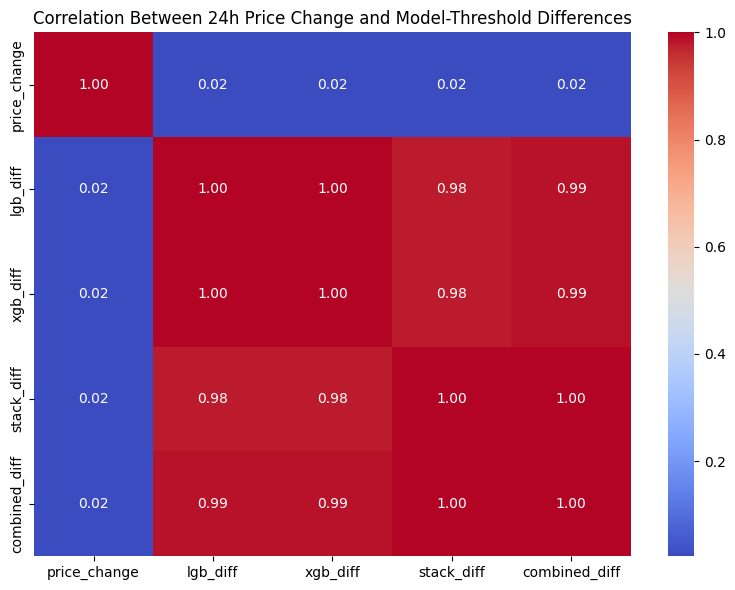

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


df_test = final_df.loc[X_test.index, ['variation_24h']].copy()
df_test['target']         = y_test.values
df_test['lgb_pr']         = lgb_pr
df_test['xgb_pr']         = xgb_pr
df_test['st_pr']          = st_pr
df_test['combined_pr']    = combined_pr

# --- Compute diff from threshold for each model ---
df_test['lgb_diff']      = df_test['lgb_pr']      - th_l
df_test['xgb_diff']      = df_test['xgb_pr']      - th_x
df_test['stack_diff']    = df_test['st_pr']       - th_s
df_test['combined_diff'] = df_test['combined_pr'] - th_c

# --- Map the actual 24h variation (price change) ---
df_test['price_change'] = df_test['variation_24h']

# --- Compute and display correlations ---
corr_cols = ['price_change', 'lgb_diff', 'xgb_diff', 'stack_diff', 'combined_diff']
correlations = df_test[corr_cols].corr()

print("Correlation Matrix:")
print(correlations)

# --- Visualize with a heatmap ---
plt.figure(figsize=(8, 6))
sns.heatmap(correlations, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Between 24h Price Change and Model‐Threshold Differences")
plt.tight_layout()
plt.show()


In [32]:
correlations.to_csv("correlations.csv", index=False)

In [31]:
# Step 1: Add a market cap cluster column
def classify_market_cap(market_cap):
    if market_cap < 10_000_000:
        return 'low'
    elif market_cap < 50_000_000:
        return 'medium'
    else:
        return 'high'

df['market_cap_cluster'] = df['market_cap'].apply(classify_market_cap)

# Step 2: Filter tokens by a specific cluster (e.g., 'low', 'medium', or 'high')
selected_cluster = 'medium'  # Change this to 'low', 'medium', or 'high' as needed
df_cluster = df[df['market_cap_cluster'] == selected_cluster]

# Step 3: Map indices of df_cluster to X_test
# Ensure the indices of df_cluster are within the test set
valid_indices = df_cluster.index.intersection(X_test.index)
valid_positions = [X_test.index.get_loc(idx) for idx in valid_indices]  # Map indices to positions
X_cluster_scaled = X_test_s[valid_positions]

# Step 4: Predict probabilities and classes for the selected cluster
df_cluster = df_cluster.loc[valid_indices]  # Align df_cluster with valid indices
df_cluster['lgb_pr'] = lgb_model.predict_proba(X_cluster_scaled)[:, 1]
df_cluster['xgb_pr'] = xgb_model.predict_proba(X_cluster_scaled)[:, 1]
df_cluster['stack_pr'] = stack.predict_proba(X_cluster_scaled)[:, 1]

df_cluster['lgb_pred'] = (df_cluster['lgb_pr'] >= th_l).astype(int)
df_cluster['xgb_pred'] = (df_cluster['xgb_pr'] >= th_x).astype(int)
df_cluster['stack_pred'] = (df_cluster['stack_pr'] >= th_s).astype(int)

# Step 5: Display results
print(f"Predictions for {selected_cluster} market cap cluster:")
print(df_cluster[['name', 'market_cap', 'market_cap_cluster', 'lgb_pred', 'xgb_pred', 'stack_pred']].head())

# Optionally save predictions
df_cluster[['name', 'market_cap', 'market_cap_cluster', 'lgb_pred', 'xgb_pred', 'stack_pred']].to_csv(f"{selected_cluster}_cluster_predictions.csv", index=False)

c:\Users\DC MEDIA AGO\Anaconda3\envs\hypescore\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\DC MEDIA AGO\Anaconda3\envs\hypescore\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\DC MEDIA AGO\Anaconda3\envs\hypescore\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\DC MEDIA AGO\Anaconda3\envs\hypescore\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
c:\Users\DC MEDIA AGO\Anaconda3\envs\hypescore\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid featur

Predictions for medium market cap cluster:
                        name    market_cap market_cap_cluster  lgb_pred  \
1648             $HYPERSKIDS  1.000837e+07             medium         1   
29652            $HYPERSKIDS  1.210891e+07             medium         1   
19170  Act I The AI Prophecy  4.829130e+07             medium         0   
19248  Act I The AI Prophecy  4.738189e+07             medium         0   
19404  Act I The AI Prophecy  4.797497e+07             medium         0   

       xgb_pred  stack_pred  
1648          1           0  
29652         1           1  
19170         0           0  
19248         0           0  
19404         0           0  


In [22]:
# --------------------------------------------------------
# A) Build df_test to include createdAt, target, and all model probs
# --------------------------------------------------------
# Assume you have:
#   final_df       – the full DataFrame including 'createdAt'
#   X_test         – the features DataFrame for your test split
#   y_test         – the true target Series for the test split
#   lgb_pr, xgb_pr, st_pr, combined_pr  – numpy arrays of model probabilities
#   th_l, th_x, th_s, th_c             – the chosen thresholds

# First, reconstruct df_test by pulling rows from final_df
df_test = final_df.loc[X_test.index, ['createdAt', 'name']].copy()
df_test['target']       = y_test.values
df_test['lgb_pr']       = lgb_pr
df_test['xgb_pr']       = xgb_pr
df_test['st_pr']        = st_pr
df_test['combined_pr']  = combined_pr

# --------------------------------------------------------
# B) Parse createdAt and extract hour
# --------------------------------------------------------
df_test['createdAt']   = pd.to_datetime(df_test['createdAt'])
df_test['hour_of_day'] = df_test['createdAt'].dt.hour

# --------------------------------------------------------
# C) Compute binary predictions at each model's threshold
# --------------------------------------------------------
df_test['lgb_pred']      = (df_test['lgb_pr']      >= th_l).astype(int)
df_test['xgb_pred']      = (df_test['xgb_pr']      >= th_x).astype(int)
df_test['stack_pred']    = (df_test['st_pr']       >= th_s).astype(int)
df_test['combined_pred'] = (df_test['combined_pr']  >= th_c).astype(int)

# --------------------------------------------------------
# D) Group by hour_of_day and compute accuracies
# --------------------------------------------------------
def hourly_accuracy(df, pred_col):
    return df.groupby('hour_of_day').apply(
        lambda g: (g[pred_col] == g['target']).mean()
    )

acc_lgb      = hourly_accuracy(df_test, 'lgb_pred').rename('acc_lgb')
acc_xgb      = hourly_accuracy(df_test, 'xgb_pred').rename('acc_xgb')
acc_stack    = hourly_accuracy(df_test, 'stack_pred').rename('acc_stack')
acc_combined = hourly_accuracy(df_test, 'combined_pred').rename('acc_combined')

# --------------------------------------------------------
# E) Assemble into one DataFrame
# --------------------------------------------------------
df_hourly_acc = pd.concat(
    [acc_lgb, acc_xgb, acc_stack, acc_combined],
    axis=1
).reset_index()

# Convert to percentages
for col in ['acc_lgb','acc_xgb','acc_stack','acc_combined']:
    df_hourly_acc[col] = (df_hourly_acc[col] * 100).round(2).astype(str) + '%'

print(df_hourly_acc)

# Optionally save
df_hourly_acc.to_csv("hourly_model_accuracy.csv", index=False)

df_hourly_acc


    hour_of_day acc_lgb acc_xgb acc_stack acc_combined
0             0  80.74%  80.74%    81.42%       81.08%
1             1  84.31%  84.31%    83.58%       83.58%
2             2  87.67%  88.36%     88.7%       89.04%
3             3  85.98%  84.47%    87.12%       88.26%
4             4  86.64%  86.28%    86.64%       86.64%
5             5  85.35%  85.71%    88.28%       87.18%
6             6  84.56%  84.19%     86.4%       85.66%
7             7  83.28%  82.94%    84.64%        84.3%
8             8  81.23%  80.51%    82.31%       81.95%
9             9  85.98%  85.61%    85.98%       85.98%
10           10   87.1%   87.5%    88.31%        87.5%
11           11  90.18%  90.18%    89.73%       89.73%
12           12   85.0%  85.45%    84.55%       84.55%
13           13  90.83%  90.42%     90.0%       90.42%
14           14  85.64%  85.15%    85.64%       86.14%
15           15  88.79%  89.24%    88.34%       87.89%
16           16  85.17%  87.08%    88.04%       88.04%
17        

C:\Users\DC MEDIA AGO\AppData\Local\Temp\ipykernel_6016\964259350.py:37: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby('hour_of_day').apply(
C:\Users\DC MEDIA AGO\AppData\Local\Temp\ipykernel_6016\964259350.py:37: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  return df.groupby('hour_of_day').apply(
C:\Users\DC MEDIA AGO\AppData\Local\Temp\ipykernel_6016\964259350.py:37: DeprecationWarning:

,hour_of_day,acc_lgb,acc_xgb,acc_stack,acc_combined
0,0,80.74%,80.74%,81.42%,81.08%
1,1,84.31%,84.31%,83.58%,83.58%
2,2,87.67%,88.36%,88.7%,89.04%
3,3,85.98%,84.47%,87.12%,88.26%
4,4,86.64%,86.28%,86.64%,86.64%
5,5,85.35%,85.71%,88.28%,87.18%
6,6,84.56%,84.19%,86.4%,85.66%
7,7,83.28%,82.94%,84.64%,84.3%
8,8,81.23%,80.51%,82.31%,81.95%
9,9,85.98%,85.61%,85.98%,85.98%


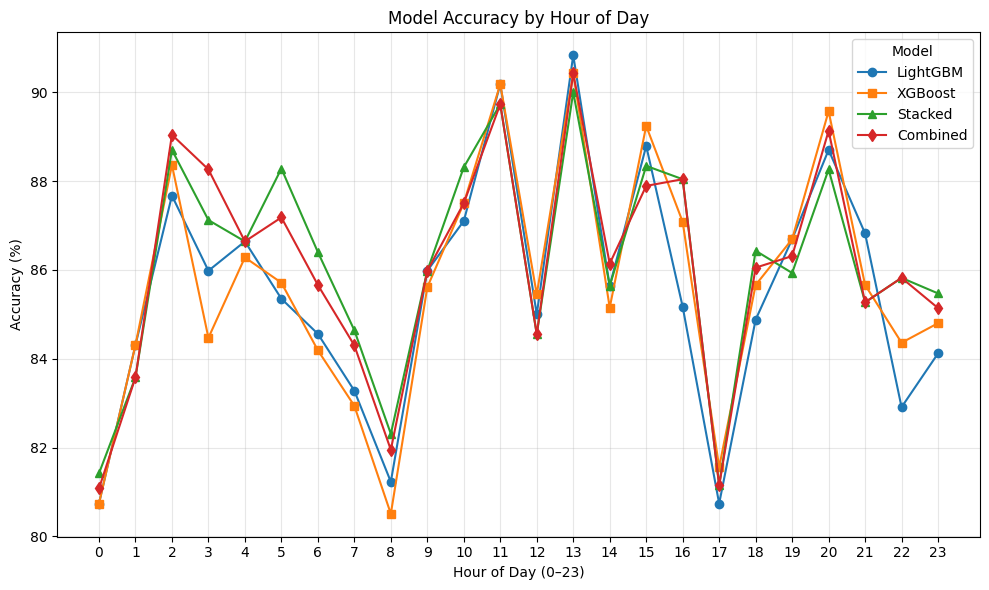

In [23]:
import matplotlib.pyplot as plt

# First, convert the percentage strings back to numeric for plotting
df_plot = df_hourly_acc.copy()
for col in ['acc_lgb','acc_xgb','acc_stack','acc_combined']:
    # strip the “%” and convert to float
    df_plot[col] = df_plot[col].str.rstrip('%').astype(float)

# Plot setup
plt.figure(figsize=(10, 6))
hours = df_plot['hour_of_day']

plt.plot(hours, df_plot['acc_lgb'],      marker='o', label='LightGBM')
plt.plot(hours, df_plot['acc_xgb'],      marker='s', label='XGBoost')
plt.plot(hours, df_plot['acc_stack'],    marker='^', label='Stacked')
plt.plot(hours, df_plot['acc_combined'], marker='d', label='Combined')

plt.xticks(range(0,24)) # show all hours
plt.xlabel('Hour of Day (0–23)')
plt.ylabel('Accuracy (%)')
plt.title('Model Accuracy by Hour of Day')
plt.grid(alpha=0.3)
plt.legend(title='Model')
plt.tight_layout()
plt.show()

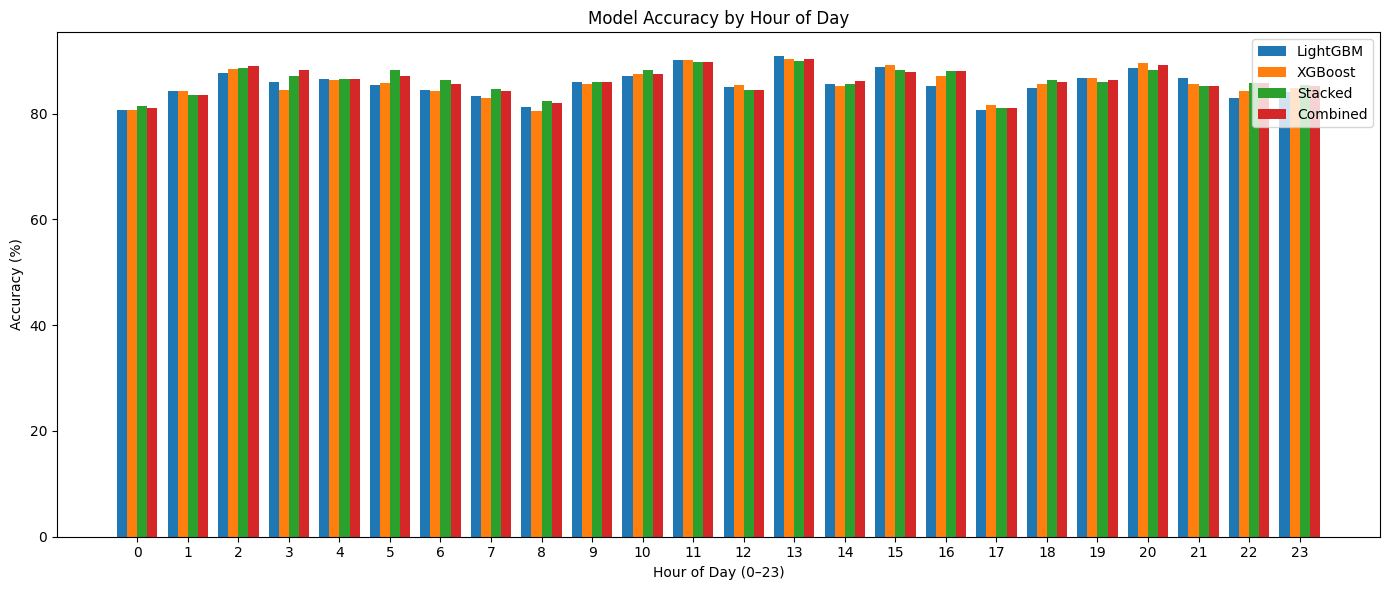

In [33]:
import matplotlib.pyplot as plt

# Convert percentage strings back to numeric
df_plot = df_hourly_acc.copy()
for col in ['acc_lgb','acc_xgb','acc_stack','acc_combined']:
    df_plot[col] = df_plot[col].str.rstrip('%').astype(float)

# Prepare bar positions
hours = df_plot['hour_of_day']
x = range(len(hours))
width = 0.2

# Plot grouped bar chart
plt.figure(figsize=(14, 6))
plt.bar([p - 1.5*width for p in x], df_plot['acc_lgb'], width=width, label='LightGBM')
plt.bar([p - 0.5*width for p in x], df_plot['acc_xgb'], width=width, label='XGBoost')
plt.bar([p + 0.5*width for p in x], df_plot['acc_stack'], width=width, label='Stacked')
plt.bar([p + 1.5*width for p in x], df_plot['acc_combined'], width=width, label='Combined')

plt.xticks(x, hours)
plt.xlabel('Hour of Day (0–23)')
plt.ylabel('Accuracy (%)')
plt.title('Model Accuracy by Hour of Day')
plt.legend()
plt.tight_layout()
plt.show()